In [1]:
import numpy as np
import scipy.special as sc_special
import tensorflow as tf 
from 	tensorflow import keras
import pandas as pd
from tensorflow.keras import optimizers,metrics,layers,Sequential
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [135]:
#data  = pd.read_csv('Data_diff.csv',sep = ',',header=0)
data = pd.read_csv('gy2020-h.csv',sep = ',',header = 0)
#data = data.sample(frac = 1) #打乱数据
data.head()

,aqi,pre_aqi,so2,no2,co,o3,pm10,pm2_5,temp,humi,w_dir,wind,rain
0,58,54,12,20,0.9,12,57,41,15,78,315,2,0.0
1,60,58,13,20,1.0,10,57,43,14,82,315,2,0.0
2,62,60,15,21,1.1,8,63,44,14,83,315,2,0.0
3,65,62,18,22,1.2,8,70,47,13,86,45,2,0.0
4,69,65,24,25,1.3,11,78,50,10,88,45,2,0.0


In [136]:
H = [5,6,7,8,9,10,11,12,13,14]
inputnum = 12
hiddennum = H[6]
outputnum = 1
numsum = inputnum*hiddennum+hiddennum+hiddennum*outputnum+outputnum 
LossArr = []
M = 5

X = data.iloc[:14230,1:]
Y = data.iloc[:14230,0]
TestX = data.iloc[14230:,1:]
TestY = data.iloc[14230:,0]
TestX.head()

,pre_aqi,so2,no2,co,o3,pm10,pm2_5,temp,humi,w_dir,wind,rain
14230,87,15,31,1.2,5,76,60,7,88,225,2,0.0
14231,82,14,33,1.2,6,71,53,7,87,0,3,0.0
14232,73,16,33,1.2,8,53,38,7,84,0,2,0.0
14233,54,15,29,1.1,13,41,27,6,83,0,2,0.0
14234,41,13,24,1.0,24,33,23,6,87,225,2,0.0


In [137]:

# O3max = np.max(np.abs(O3Y),axis=0)
# O3mean = np.mean(O3Y,axis=0)

def data_progress(X,TestX):
    for i in range(0,X.shape[1]):
        TestX.iloc[:,i] -= np.mean(X,axis=0)[i]
        TestX.iloc[:,i] /= np.max(np.abs(X),axis=0)[i]
        X.iloc[:,i] -= np.mean(X,axis=0)[i]
        X.iloc[:,i] /= np.max(np.abs(X),axis=0)[i]

        
    return 0
def data_progressY(Y,TestY):
    Y -= np.mean(Y,axis=0)
    Y /= np.max(np.abs(Y),axis=0)
    TestY -= np.mean(Y,axis=0)
    TestY /= np.max(np.abs(Y),axis=0)
    return 1
data_progress(X,TestX)


0

In [144]:
X1 = X.iloc[:2846,:]
Y1 = Y[:2846]
X2 = X.iloc[2846:5692,:]
Y2 = Y[2846:5692]
X3 = X.iloc[5692:8538,:]
Y3 = Y[5692:8538]
X4 = X.iloc[8538:11384,:]
Y4 = Y[8538:11384]
X5 = X.iloc[11384:,:]
Y5 = Y[11384:]
len(X5),len(Y5)

(2846, 2846)

In [145]:
TrainX = [X1,X2,X3,X4,X5]
TrainY = [Y1,Y2,Y3,Y4,Y5]

#  CS

In [200]:

#n：布谷鸟数  m：布谷鸟的维度
def cuckoo_search(n, m, lower_boundary, upper_boundary, iter_num = 20,pa = 0.25, beta = 1.5, step_size = 0.1,alpha=0.77,xn=0.33):

    num=1
    # get initial nests' locations 
    nests,best_nest,best_fitness,lossness = generate_nests(n, m,alpha,xn, lower_boundary, upper_boundary) #alpha,xn用于tent初始化阈值和初值设置
    
    # get the best nest and record it
    LossArr.append(best_fitness) #全局变量，保存每代最佳适应度值
    

    print('\r\n BEST_LOSSNESS IS %.2f : \r\n',best_fitness)

    for _ in range(iter_num):
        
        print('\r\n******************************************************第 %d 代开始迭代优化************************************************************\r\n'%num)
        nests = update_nests(lower_boundary, upper_boundary, nests, best_nest, lossness, step_size,best_fitness)
        nests = abandon_nests(nests, lower_boundary, upper_boundary, pa)
        
        print('\r\n*****************************************************第 %d 次迭代，计算适应度********************************************************\r\n'%num)
        lossness,_ = calc_fitness( nests)
        print('\r\n*********************************************************第 %d 次迭代结束************************************************************\r\n'%num)
        
        min_loss_index = np.argmin(lossness)
        min_loss = lossness[min_loss_index]
        min_nestloss = nests[min_loss_index]
        LossArr.append(min_loss)
            
        if min_loss < best_fitness  : #and  min_loss_fit > best_two_fitness
            best_nest = min_nestloss
            best_fitness = min_loss
            print('\r\n******')
            print('\r\n 第 %d 次迭代最优Loss是 %.2f : \r\n'%(num,best_fitness))
            print('\r\n******\r\n')
        num+=1

    return (best_nest, best_fitness)

In [201]:
def generate_nests(n, m,alpha,xn, lower_boundary, upper_boundary):

# #随机生成nest
#     lower_boundary = np.array(lower_boundary)
#     upper_boundary = np.array(upper_boundary)
#     nests = np.empty((n, m))

#     for each_nest in range(n):
#         nests[each_nest] = lower_boundary + np.array([np.random.rand() for _ in range(m)]) * (upper_boundary - lower_boundary)

#Tent混沌反向初始化

# # #混沌初始化
    nests = np.empty((n, m))
    sig_nest = np.empty(m)
    alpha = alpha
    xn = xn
    for i in range(0,n):   #*2 值域为【-1,1】 *6 值域为[-3,3]
        for j in range(0,m):
            if 0<=xn<alpha:
                xn = xn/alpha
                sig_nest[j]=(xn-0.5)*6
            elif alpha <= xn <= 1:
                xn = (1-xn)/(1-alpha)
                sig_nest[j] = (xn-0.5)*6
            nests[i] = sig_nest
            
# #反向初始化            
    renests = -1 * nests   #定义：Pi = ai + bi - pi  生成反向nests
    
# #拼接两个初始化nests
    nests = np.vstack((nests,renests))  #拼接nests和renests 准备计算适应度选择最优的n个nest
    
#计算适应度
    lossness,_ = calc_fitness( nests) 
    
# # #根据loss值排序
    arrIndex = np.argsort(lossness)   #获得排序数组  从小到大
    lossness = lossness[arrIndex]     #将lossness数组按照从小到大排序
    nests = nests[arrIndex]    #将nests也按照相同序列进行排序，保证和lossness对齐
    
#删除多余的n组nest，这里从最底下开始一个个删，因为已经排好序了，所以删除的为效果最差的
    for i in range(n):
        nests = np.delete(nests,-1,0)
        lossness = np.delete(lossness,-1,0)
#现在的nests是按照loss排序的，第一个loss最小

    return nests,nests[0],lossness[0],lossness

In [202]:
def update_nests(lower_boundary, upper_boundary, nests, best_nest, lossness, step_coefficient,bestfitness):

    lower_boundary = np.array(lower_boundary)
    upper_boundary = np.array(upper_boundary)
    n, m = nests.shape
    # 莱维飞行生成步长：较长时间的短步长和较短时间的长步长
    #生成的步长的shape也是n*m，保证所有元素得到更新
    #这个步长通过step_size来控制大小
    steps = levy_flight(n, m, 1.5)
    new_nests = nests.copy()

    for each_nest in range(n):
        # coefficient 0.01 is to avoid levy flights becoming too aggresive
        # and (nest[each_nest] - best_nest) 保留了最佳nest，但会导致局部最优
        step_size = step_coefficient * steps[each_nest] # * (nests[each_nest] - best_nest)
        step_direction = np.random.rand(m) #0-1均匀概率分布生成方向
        #新的布谷鸟在原来的基础上加上步长和方向
        new_nests[each_nest] += step_size * step_direction  
        # apply boundary condtions
        new_nests[each_nest][new_nests[each_nest] < lower_boundary] = lower_boundary[new_nests[each_nest] < lower_boundary]
        new_nests[each_nest][new_nests[each_nest] > upper_boundary] = upper_boundary[new_nests[each_nest] > upper_boundary]

    new_losses,new_nests = calc_fitness(new_nests)
    #适应度更好的才更新过去
    
    nests[new_losses < lossness] = new_nests[new_losses < lossness] 
    return nests

In [203]:
def abandon_nests(nests, lower_boundary, upper_boundary, pa):

    lower_boundary = np.array(lower_boundary)
    upper_boundary = np.array(upper_boundary)
    n, m = nests.shape
    for each_nest in range(n):  
        #pa概率抛弃，抛弃后重新生成
        if (np.random.rand() < pa):
            #局部随机行走生成步长
            #随机两个种群相差*一个0-1的随机数
            step_size = np.random.rand() * (nests[np.random.randint(0, n)] - nests[np.random.randint(0, n)])
            nests[each_nest] += step_size
            # apply boundary condtions
            nests[each_nest][nests[each_nest] < lower_boundary] = lower_boundary[nests[each_nest] < lower_boundary]
            nests[each_nest][nests[each_nest] > upper_boundary] = upper_boundary[nests[each_nest] > upper_boundary]
    
    return nests

In [204]:
def levy_flight(n, m, beta):

    sigma_u = (sc_special.gamma(1+beta)*np.sin(np.pi*beta/2)/(sc_special.gamma((1+beta)/2)*beta*(2**((beta-1)/2))))**(1/beta)
    sigma_v = 1

    u =  np.random.normal(0, sigma_u, (n, m))
    v = np.random.normal(0, sigma_v, (n, m))

    steps = u/((np.abs(v))**(1/beta))

    return steps

In [207]:
def calc_fitness(nests):
    
    n, m = nests.shape
    lossness = np.empty(n)
    new_nests = nests
    for Sig_nest in range(n):
        chrom = nests[Sig_nest]
        #分解模型参数
        w1 = chrom[:inputnum*hiddennum]
        w1 = w1.reshape(inputnum,hiddennum)
        b1 = chrom[inputnum*hiddennum:inputnum*hiddennum+hiddennum]
        w2 = chrom[inputnum*hiddennum+hiddennum:inputnum*hiddennum+hiddennum+hiddennum*outputnum]
        w2 = w2.reshape(hiddennum,outputnum)
        b2 = chrom[inputnum*hiddennum+hiddennum+hiddennum*outputnum:]

        WB_l1 = (w1,b1)
        WB_l2 = (w2,b2)
        #创建模型，并赋予参数
        model = keras.Sequential([
            keras.layers.Dense(hiddennum,activation='relu',name='l1'),
            keras.layers.Dense(outputnum,name='l2')
        ])
        model.build(input_shape=[None,inputnum])
        
        #model.summary()
        model.compile(optimizer=optimizers.Adam(lr=0.01),
                    loss='mse',)
        
        layer1 = model.get_layer('l1')
        layer2 = model.get_layer('l2')
        layer1.set_weights(WB_l1)
        layer2.set_weights(WB_l2)
        
        #训练模型
        #！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！下面两句输入数据集
        model.fit(X,Y,epochs=1)
        loss = model.evaluate(X,Y)  #这里是用验证集评估，其实应该用测试集吧 evaluate产生两个结果，前面是损失，后面是准确率
        lossness[Sig_nest] = loss
        
        
        (k1,y1) = layer1.get_weights()  #获取训练后的神经网络权值，并赋值给c
        (k2,y2) = layer2.get_weights()
        c=k1.reshape(1,-1).tolist()[0] + y1.reshape(1,-1).tolist()[0] + k2.reshape(1,-1).tolist()[0] + y2.reshape(1,-1).tolist()[0]
        new_nests[Sig_nest] = c
        
        
#         if(acc>bestfitness): #在计算适应度的过程当中，发现有更好的适应度就把参数保存
#             #model.save_weights('my_model_fun.h5')
#             bestfitness = acc
    return lossness,new_nests

In [208]:
 nest,loss = cuckoo_search(5,numsum, low,upp, step_size = 0.4,alpha=0.77,xn=0.33)

445/445 [==============================] - 1s 972us/step - loss: 33.2223

 BEST_LOSSNESS IS %.2f : 
 15.689727783203125

******************************************************第 1 代开始迭代优化************************************************************

445/445 [==============================] - 0s 567us/step - loss: 8.4606

*****************************************************第 1 次迭代，计算适应度********************************************************

445/445 [==============================] - 0s 610us/step - loss: 7.0012

*********************************************************第 1 次迭代结束************************************************************


******

 第 1 次迭代最优Loss是 6.37 : 


******


******************************************************第 2 代开始迭代优化************************************************************

445/445 [==============================] - 0s 654us/step - loss: 6.6872

*****************************************************第 2 次迭代，计算适应度********************************************

445/445 [==============================] - 0s 612us/step - loss: 6.2882

*****************************************************第 4 次迭代，计算适应度********************************************************

445/445 [==============================] - 1s 979us/step - loss: 5.9205

*********************************************************第 4 次迭代结束************************************************************


******

 第 4 次迭代最优Loss是 3.85 : 


******


******************************************************第 5 代开始迭代优化************************************************************

445/445 [==============================] - 0s 830us/step - loss: 6.5902

*****************************************************第 5 次迭代，计算适应度********************************************************

445/445 [==============================] - 0s 894us/step - loss: 5.5828

*********************************************************第 5 次迭代结束************************************************************


******

 第 5 次迭代最优Loss是 3.66 : 


445/445 [==============================] - 0s 875us/step - loss: 9.6085

*********************************************************第 8 次迭代结束************************************************************


******************************************************第 9 代开始迭代优化************************************************************

445/445 [==============================] - 0s 666us/step - loss: 7.1008

*****************************************************第 9 次迭代，计算适应度********************************************************

445/445 [==============================] - 0s 689us/step - loss: 6.3989

*********************************************************第 9 次迭代结束************************************************************


******************************************************第 10 代开始迭代优化************************************************************

445/445 [==============================] - 0s 635us/step - loss: 6.6047

*****************************************************第 10 次迭代，计算适应度****

445/445 [==============================] - 0s 614us/step - loss: 5.5555

*****************************************************第 13 次迭代，计算适应度********************************************************

445/445 [==============================] - 0s 646us/step - loss: 4.8646

*********************************************************第 13 次迭代结束************************************************************


******************************************************第 14 代开始迭代优化************************************************************

445/445 [==============================] - 0s 590us/step - loss: 4.8641

*****************************************************第 14 次迭代，计算适应度********************************************************

445/445 [==============================] - 0s 629us/step - loss: 4.5085

*********************************************************第 14 次迭代结束************************************************************


******************************************************第 15 代开始迭代优化****

445/445 [==============================] - 0s 815us/step - loss: 3.8291

*********************************************************第 17 次迭代结束************************************************************


******

 第 17 次迭代最优Loss是 3.04 : 


******


******************************************************第 18 代开始迭代优化************************************************************

445/445 [==============================] - 0s 565us/step - loss: 4.0426

*****************************************************第 18 次迭代，计算适应度********************************************************

445/445 [==============================] - 0s 738us/step - loss: 5.8515

*********************************************************第 18 次迭代结束************************************************************


******

 第 18 次迭代最优Loss是 2.82 : 


******


******************************************************第 19 代开始迭代优化************************************************************

445/445 [==============================] - 0s 675us/

In [74]:
low = -5*np.ones(numsum)
upp = 5*np.ones(numsum)
i = 0
j = 0
best_nest = [] #保存每次CS最佳loss对应的nest，用于赋值给不同神经网络构成多个弱分类器
best_loss = []
best_fitness = []
alpha = [0.22,0.46,0.65,0.72,0.90]  #alpha不取0.5,0<alpha<1
xn = [0.90,0.70,0.55,0.34,0.19]  #xn值不能和alpha值相同，否则将演化为周期系统，就不是混沌系统了
for i in range(M):
    print('第 %d 个CS算法开始'%(i+1))
    nest,loss = cuckoo_search(5,numsum, low,upp, step_size = 0.4,alpha=alpha[i],xn=xn[i])
    best_nest.append(nest)
    best_loss.append(loss)

for j in range(M):    
    print('第 %d 个CS最优loss为:%.5f!'%(j+1,best_loss[j]))

第 1 个CS算法开始
2/2 [==============================] - 0s 6ms/step - loss: nan

 BEST_LOSSNESS IS %.2f : 
 nan

******************************************************第 1 代开始迭代优化************************************************************

445/445 [==============================] - 1s 1ms/step - loss: 20.2087


2/2 [==============================] - 0s 2ms/step - loss: nan

*****************************************************第 1 次迭代，计算适应度********************************************************

2/2 [==============================] - 0s 5ms/step - loss: nan

*********************************************************第 1 次迭代结束************************************************************


******************************************************第 2 代开始迭代优化************************************************************

445/445 [==============================] - 1s 1ms/step - loss: 8.5952


2/2 [==============================] - 0s 8ms/step - loss: nan

*****************************************************第 2 次迭代，计算适应度********************************************************

2/2 [==============================] - 0s 5ms/step - loss: nan

*********************************************************第 2 次迭代结束************************************************************


******************************************************第 3 代开始迭代优化************************************************************



2/2 [==============================] - 0s 2ms/step - loss: nan

*****************************************************第 3 次迭代，计算适应度********************************************************

445/445 [==============================] - 1s 1ms/step - loss: 7.4105


2/2 [==============================] - 0s 4ms/step - loss: nan

*********************************************************第 3 次迭代结束************************************************************


******************************************************第 4 代开始迭代优化************************************************************

2/2 [==============================] - 0s 2ms/step - loss: nan

*****************************************************第 4 次迭代，计算适应度********************************************************

445/445 [==============================] - 1s 1ms/step - loss: 8.8425


2/2 [==============================] - 0s 3ms/step - loss: nan

*********************************************************第 4 次迭代结束************************************************************


******************************************************第 5 代开始迭代优化************************************************************

2/2 [==============================] - 0s 3ms/step - loss: nan

*****************************************************第 5 次迭代，计算适应度********************************************************

445/445 [==============================] - 1s 1ms/step - loss: 5.2326


2/2 [==============================] - 0s 3ms/step - loss: nan

*********************************************************第 5 次迭代结束************************************************************


******************************************************第 6 代开始迭代优化************************************************************

2/2 [==============================] - 0s 5ms/step - loss: nan

*****************************************************第 6 次迭代，计算适应度********************************************************

445/445 [==============================] - 1s 1ms/step - loss: 78.2508


2/2 [==============================] - 0s 3ms/step - loss: nan

*********************************************************第 6 次迭代结束************************************************************


******************************************************第 7 代开始迭代优化************************************************************

2/2 [==============================] - 0s 3ms/step - loss: nan

*****************************************************第 7 次迭代，计算适应度********************************************************

445/445 [==============================] - 1s 1ms/step - loss: 6.7738


2/2 [==============================] - 0s 7ms/step - loss: nan

*********************************************************第 7 次迭代结束************************************************************


******************************************************第 8 代开始迭代优化************************************************************

2/2 [==============================] - 0s 2ms/step - loss: nan

*****************************************************第 8 次迭代，计算适应度********************************************************



2/2 [==============================] - 0s 2ms/step - loss: nan

*********************************************************第 8 次迭代结束************************************************************


******************************************************第 9 代开始迭代优化************************************************************

445/445 [==============================] - 1s 1ms/step - loss: 5.1440


2/2 [==============================] - 0s 3ms/step - loss: nan

*****************************************************第 9 次迭代，计算适应度********************************************************

2/2 [==============================] - 0s 3ms/step - loss: nan

*********************************************************第 9 次迭代结束************************************************************


******************************************************第 10 代开始迭代优化************************************************************

445/445 [==============================] - 1s 1ms/step - loss: 6.0809


2/2 [==============================] - 0s 3ms/step - loss: nan

*****************************************************第 10 次迭代，计算适应度********************************************************

2/2 [==============================] - 0s 3ms/step - loss: nan

*********************************************************第 10 次迭代结束************************************************************

第 2 个CS算法开始
2/2 [==============================] - 0s 4ms/step - loss: nan


2/2 [==============================] - 0s 5ms/step - loss: nan

 BEST_LOSSNESS IS %.2f : 
 nan

******************************************************第 1 代开始迭代优化************************************************************

445/445 [==============================] - 1s 1ms/step - loss: 12.4853


2/2 [==============================] - 0s 4ms/step - loss: nan

*****************************************************第 1 次迭代，计算适应度********************************************************

2/2 [==============================] - 0s 2ms/step - loss: nan

*********************************************************第 1 次迭代结束************************************************************


******************************************************第 2 代开始迭代优化************************************************************

445/445 [==============================] - 1s 1ms/step - loss: 34.6086


2/2 [==============================] - 0s 4ms/step - loss: nan

*****************************************************第 2 次迭代，计算适应度********************************************************

2/2 [==============================] - 0s 3ms/step - loss: nan

*********************************************************第 2 次迭代结束************************************************************


******************************************************第 3 代开始迭代优化************************************************************

445/445 [==============================] - 1s 1ms/step - loss: 8.6462


2/2 [==============================] - 0s 2ms/step - loss: nan

*****************************************************第 3 次迭代，计算适应度********************************************************

2/2 [==============================] - 0s 3ms/step - loss: nan

*********************************************************第 3 次迭代结束************************************************************


******************************************************第 4 代开始迭代优化************************************************************



2/2 [==============================] - 0s 4ms/step - loss: nan

*****************************************************第 4 次迭代，计算适应度********************************************************

445/445 [==============================] - 1s 1ms/step - loss: 6.4945


2/2 [==============================] - 0s 4ms/step - loss: nan

*********************************************************第 4 次迭代结束************************************************************


******************************************************第 5 代开始迭代优化************************************************************

2/2 [==============================] - 0s 2ms/step - loss: nan

*****************************************************第 5 次迭代，计算适应度********************************************************

445/445 [==============================] - 1s 1ms/step - loss: 5.6693


2/2 [==============================] - 0s 2ms/step - loss: nan

*********************************************************第 5 次迭代结束************************************************************


******************************************************第 6 代开始迭代优化************************************************************

2/2 [==============================] - 0s 3ms/step - loss: nan

*****************************************************第 6 次迭代，计算适应度********************************************************

445/445 [==============================] - 1s 1ms/step - loss: 5.5449


2/2 [==============================] - 0s 2ms/step - loss: nan

*********************************************************第 6 次迭代结束************************************************************


******************************************************第 7 代开始迭代优化************************************************************

2/2 [==============================] - 0s 6ms/step - loss: nan

*****************************************************第 7 次迭代，计算适应度********************************************************

445/445 [==============================] - 1s 1ms/step - loss: 5.4822


2/2 [==============================] - 0s 3ms/step - loss: nan

*********************************************************第 7 次迭代结束************************************************************


******************************************************第 8 代开始迭代优化************************************************************

2/2 [==============================] - 0s 3ms/step - loss: nan

*****************************************************第 8 次迭代，计算适应度********************************************************

445/445 [==============================] - 1s 2ms/step - loss: 28.5031


2/2 [==============================] - 0s 3ms/step - loss: nan

*********************************************************第 8 次迭代结束************************************************************


******************************************************第 9 代开始迭代优化************************************************************

2/2 [==============================] - 0s 6ms/step - loss: nan

*****************************************************第 9 次迭代，计算适应度********************************************************



2/2 [==============================] - 0s 4ms/step - loss: nan

*********************************************************第 9 次迭代结束************************************************************


******************************************************第 10 代开始迭代优化************************************************************

445/445 [==============================] - 1s 1ms/step - loss: 8.0496


2/2 [==============================] - 0s 4ms/step - loss: nan

*****************************************************第 10 次迭代，计算适应度********************************************************

2/2 [==============================] - 0s 4ms/step - loss: nan

*********************************************************第 10 次迭代结束************************************************************

第 3 个CS算法开始
2/2 [==============================] - 0s 3ms/step - loss: nan


2/2 [==============================] - 0s 7ms/step - loss: nan

 BEST_LOSSNESS IS %.2f : 
 nan

******************************************************第 1 代开始迭代优化************************************************************

445/445 [==============================] - 1s 1ms/step - loss: 12.8824


2/2 [==============================] - 0s 3ms/step - loss: nan

*****************************************************第 1 次迭代，计算适应度********************************************************

2/2 [==============================] - 0s 3ms/step - loss: nan

*********************************************************第 1 次迭代结束************************************************************


******************************************************第 2 代开始迭代优化************************************************************

445/445 [==============================] - 1s 1ms/step - loss: 26.8790


2/2 [==============================] - 0s 2ms/step - loss: nan

*****************************************************第 2 次迭代，计算适应度********************************************************

2/2 [==============================] - 0s 5ms/step - loss: nan

*********************************************************第 2 次迭代结束************************************************************


******************************************************第 3 代开始迭代优化************************************************************

445/445 [==============================] - 1s 1ms/step - loss: 7.8334


2/2 [==============================] - 0s 3ms/step - loss: nan

*****************************************************第 3 次迭代，计算适应度********************************************************

2/2 [==============================] - 0s 3ms/step - loss: nan

*********************************************************第 3 次迭代结束************************************************************


******************************************************第 4 代开始迭代优化************************************************************

445/445 [==============================] - 1s 1ms/step - loss: 8.5216


2/2 [==============================] - 0s 3ms/step - loss: nan

*****************************************************第 4 次迭代，计算适应度********************************************************

2/2 [==============================] - 0s 5ms/step - loss: nan

*********************************************************第 4 次迭代结束************************************************************


******************************************************第 5 代开始迭代优化************************************************************



2/2 [==============================] - 0s 3ms/step - loss: nan

*****************************************************第 5 次迭代，计算适应度********************************************************

445/445 [==============================] - 1s 1ms/step - loss: 6.6092


2/2 [==============================] - 0s 4ms/step - loss: nan

*********************************************************第 5 次迭代结束************************************************************


******************************************************第 6 代开始迭代优化************************************************************

2/2 [==============================] - 0s 3ms/step - loss: nan

*****************************************************第 6 次迭代，计算适应度********************************************************

445/445 [==============================] - 1s 1ms/step - loss: 207.7356


2/2 [==============================] - 0s 4ms/step - loss: nan

*********************************************************第 6 次迭代结束************************************************************


******************************************************第 7 代开始迭代优化************************************************************

2/2 [==============================] - 0s 3ms/step - loss: nan

*****************************************************第 7 次迭代，计算适应度********************************************************

445/445 [==============================] - 1s 985us/step - loss: 6.9655


2/2 [==============================] - 0s 3ms/step - loss: nan

*********************************************************第 7 次迭代结束************************************************************


******************************************************第 8 代开始迭代优化************************************************************

2/2 [==============================] - 0s 3ms/step - loss: nan

*****************************************************第 8 次迭代，计算适应度********************************************************

445/445 [==============================] - 1s 1ms/step - loss: 5.3910


2/2 [==============================] - 0s 5ms/step - loss: nan

*********************************************************第 8 次迭代结束************************************************************


******************************************************第 9 代开始迭代优化************************************************************

2/2 [==============================] - 0s 4ms/step - loss: nan

*****************************************************第 9 次迭代，计算适应度********************************************************

445/445 [==============================] - 1s 2ms/step - loss: 5.6365


2/2 [==============================] - 0s 6ms/step - loss: nan

*********************************************************第 9 次迭代结束************************************************************


******************************************************第 10 代开始迭代优化************************************************************

2/2 [==============================] - 0s 2ms/step - loss: nan

*****************************************************第 10 次迭代，计算适应度********************************************************



2/2 [==============================] - 0s 3ms/step - loss: nan

*********************************************************第 10 次迭代结束************************************************************

第 4 个CS算法开始
445/445 [==============================] - 1s 1ms/step - loss: 577.0634


2/2 [==============================] - 0s 7ms/step - loss: nan

 BEST_LOSSNESS IS %.2f : 
 nan

******************************************************第 1 代开始迭代优化************************************************************

445/445 [==============================] - 1s 1ms/step - loss: 16.9772


2/2 [==============================] - 0s 3ms/step - loss: nan

*****************************************************第 1 次迭代，计算适应度********************************************************

2/2 [==============================] - 0s 3ms/step - loss: nan

*********************************************************第 1 次迭代结束************************************************************


******************************************************第 2 代开始迭代优化************************************************************

445/445 [==============================] - 1s 1ms/step - loss: 13.7882


2/2 [==============================] - 0s 3ms/step - loss: nan

*****************************************************第 2 次迭代，计算适应度********************************************************

2/2 [==============================] - 0s 3ms/step - loss: nan

*********************************************************第 2 次迭代结束************************************************************


******************************************************第 3 代开始迭代优化************************************************************

445/445 [==============================] - 1s 985us/step - loss: 8.2358


2/2 [==============================] - 0s 4ms/step - loss: nan

*****************************************************第 3 次迭代，计算适应度********************************************************

2/2 [==============================] - 0s 5ms/step - loss: nan

*********************************************************第 3 次迭代结束************************************************************


******************************************************第 4 代开始迭代优化************************************************************

445/445 [==============================] - 1s 1ms/step - loss: 16.4908


2/2 [==============================] - 0s 2ms/step - loss: nan

*****************************************************第 4 次迭代，计算适应度********************************************************

2/2 [==============================] - 0s 3ms/step - loss: nan

*********************************************************第 4 次迭代结束************************************************************


******************************************************第 5 代开始迭代优化************************************************************

445/445 [==============================] - 1s 1ms/step - loss: 28.6412


2/2 [==============================] - 0s 5ms/step - loss: nan

*****************************************************第 5 次迭代，计算适应度********************************************************

2/2 [==============================] - 0s 4ms/step - loss: nan

*********************************************************第 5 次迭代结束************************************************************


******************************************************第 6 代开始迭代优化************************************************************



2/2 [==============================] - 0s 4ms/step - loss: nan

*****************************************************第 6 次迭代，计算适应度********************************************************

445/445 [==============================] - 1s 1ms/step - loss: 173.7273


2/2 [==============================] - 0s 4ms/step - loss: nan

*********************************************************第 6 次迭代结束************************************************************


******************************************************第 7 代开始迭代优化************************************************************

2/2 [==============================] - 0s 4ms/step - loss: nan

*****************************************************第 7 次迭代，计算适应度********************************************************

445/445 [==============================] - 1s 1ms/step - loss: 8.2147


2/2 [==============================] - 0s 4ms/step - loss: nan

*********************************************************第 7 次迭代结束************************************************************


******************************************************第 8 代开始迭代优化************************************************************

2/2 [==============================] - 0s 5ms/step - loss: nan

*****************************************************第 8 次迭代，计算适应度********************************************************

445/445 [==============================] - 1s 1ms/step - loss: 6.8212


2/2 [==============================] - 0s 3ms/step - loss: nan

*********************************************************第 8 次迭代结束************************************************************


******************************************************第 9 代开始迭代优化************************************************************

2/2 [==============================] - 0s 2ms/step - loss: nan

*****************************************************第 9 次迭代，计算适应度********************************************************

445/445 [==============================] - 1s 976us/step - loss: 4.5055


2/2 [==============================] - 0s 4ms/step - loss: nan

*********************************************************第 9 次迭代结束************************************************************


******************************************************第 10 代开始迭代优化************************************************************

2/2 [==============================] - 0s 3ms/step - loss: nan

*****************************************************第 10 次迭代，计算适应度********************************************************

445/445 [==============================] - 1s 967us/step - loss: 8.0129


2/2 [==============================] - 0s 3ms/step - loss: nan

*********************************************************第 10 次迭代结束************************************************************

第 5 个CS算法开始
445/445 [==============================] - 1s 1ms/step - loss: 2331.9602


2/2 [==============================] - 0s 3ms/step - loss: nan

 BEST_LOSSNESS IS %.2f : 
 nan

******************************************************第 1 代开始迭代优化************************************************************

2/2 [==============================] - 0s 5ms/step - loss: nan

*****************************************************第 1 次迭代，计算适应度********************************************************



2/2 [==============================] - 0s 2ms/step - loss: nan

*********************************************************第 1 次迭代结束************************************************************


******************************************************第 2 代开始迭代优化************************************************************

445/445 [==============================] - 1s 1ms/step - loss: 9.2234


2/2 [==============================] - 0s 2ms/step - loss: nan

*****************************************************第 2 次迭代，计算适应度********************************************************

2/2 [==============================] - 0s 3ms/step - loss: nan

*********************************************************第 2 次迭代结束************************************************************


******************************************************第 3 代开始迭代优化************************************************************

445/445 [==============================] - 1s 1ms/step - loss: 10.5226


2/2 [==============================] - 0s 3ms/step - loss: nan

*****************************************************第 3 次迭代，计算适应度********************************************************

2/2 [==============================] - 0s 4ms/step - loss: nan

*********************************************************第 3 次迭代结束************************************************************


******************************************************第 4 代开始迭代优化************************************************************

445/445 [==============================] - 1s 1ms/step - loss: 10.2343


2/2 [==============================] - 0s 3ms/step - loss: nan

*****************************************************第 4 次迭代，计算适应度********************************************************

2/2 [==============================] - 0s 3ms/step - loss: nan

*********************************************************第 4 次迭代结束************************************************************


******************************************************第 5 代开始迭代优化************************************************************

445/445 [==============================] - 1s 1ms/step - loss: 9.9282


2/2 [==============================] - 0s 2ms/step - loss: nan

*****************************************************第 5 次迭代，计算适应度********************************************************

2/2 [==============================] - 0s 4ms/step - loss: nan

*********************************************************第 5 次迭代结束************************************************************


******************************************************第 6 代开始迭代优化************************************************************

445/445 [==============================] - 1s 1ms/step - loss: 18.6649


2/2 [==============================] - 0s 3ms/step - loss: nan

*****************************************************第 6 次迭代，计算适应度********************************************************

2/2 [==============================] - 0s 4ms/step - loss: nan

*********************************************************第 6 次迭代结束************************************************************


******************************************************第 7 代开始迭代优化************************************************************



2/2 [==============================] - 0s 4ms/step - loss: nan

*****************************************************第 7 次迭代，计算适应度********************************************************

445/445 [==============================] - 1s 1ms/step - loss: 6.2407


2/2 [==============================] - 0s 3ms/step - loss: nan

*********************************************************第 7 次迭代结束************************************************************


******************************************************第 8 代开始迭代优化************************************************************

2/2 [==============================] - 0s 2ms/step - loss: nan

*****************************************************第 8 次迭代，计算适应度********************************************************

445/445 [==============================] - 1s 1ms/step - loss: 6.5325


2/2 [==============================] - 0s 5ms/step - loss: nan

*********************************************************第 8 次迭代结束************************************************************


******************************************************第 9 代开始迭代优化************************************************************

2/2 [==============================] - 0s 5ms/step - loss: nan

*****************************************************第 9 次迭代，计算适应度********************************************************

445/445 [==============================] - 1s 1ms/step - loss: 7.8315


2/2 [==============================] - 0s 5ms/step - loss: nan

*********************************************************第 9 次迭代结束************************************************************


******************************************************第 10 代开始迭代优化************************************************************

2/2 [==============================] - 0s 3ms/step - loss: nan

*****************************************************第 10 次迭代，计算适应度********************************************************

445/445 [==============================] - 1s 1ms/step - loss: 6.1163


2/2 [==============================] - 0s 6ms/step - loss: nan

*********************************************************第 10 次迭代结束************************************************************

第 1 个CS最优loss为:nan!
第 2 个CS最优loss为:nan!
第 3 个CS最优loss为:nan!
第 4 个CS最优loss为:nan!
第 5 个CS最优loss为:nan!


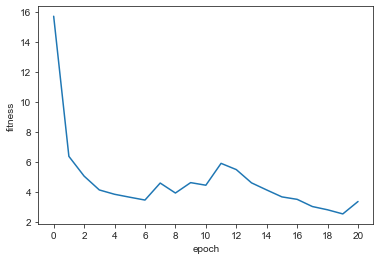

In [210]:
sns.set_style("ticks")
x = list(range(0,len(LossArr)))
fig = sns.lineplot(x,LossArr)
fig.set_xticks(ticks=[0,2,4,6,8,10,12,14,16,18,20])
plt.xlabel("epoch")
plt.ylabel("fitness")
scatter_fig = fig.get_figure()
scatter_fig.savefig('./pic/Adaboost-Loss', dpi = 400)

In [199]:
#LossArr = np.delete(LossArr,0)
LossArr

[]

# 搭建神经网络

In [168]:
Models = []
for i in range(0,M):
    chrom = best_nest[i]
    w1 = chrom[:inputnum*hiddennum]
    w1 = w1.reshape(inputnum,hiddennum)
    b1 = chrom[inputnum*hiddennum:inputnum*hiddennum+hiddennum]
    w2 = chrom[inputnum*hiddennum+hiddennum:inputnum*hiddennum+hiddennum+hiddennum*outputnum]
    w2 = w2.reshape(hiddennum,outputnum)
    b2 = chrom[inputnum*hiddennum+hiddennum+hiddennum*outputnum:]

    WB_layer1 = (w1,b1)
    WB_layer2 = (w2,b2)

    model = keras.Sequential([
        keras.layers.Dense(hiddennum,name='layer1',activation='relu'),
        keras.layers.Dense(outputnum,name='layer2')
        ])


    model.build(input_shape=[None,inputnum])
    #model.summary()
    model.compile(optimizer=optimizers.Adam(lr=0.005),
                loss='mse',)
    

    layer1 = model.get_layer('layer1')
    layer2 = model.get_layer('layer2')
    layer1.set_weights(WB_layer1)
    layer2.set_weights(WB_layer2)

    model.fit(TrainX[i],TrainY[i],epochs=100)
    Models.append(model)

Epoch 1/100
89/89 [==============================] - 0s 1ms/step - loss: 3.7706
Epoch 2/100
89/89 [==============================] - 0s 1ms/step - loss: 3.2846
Epoch 3/100
89/89 [==============================] - 0s 1ms/step - loss: 3.5337
Epoch 4/100
89/89 [==============================] - 0s 2ms/step - loss: 3.3148
Epoch 5/100
89/89 [==============================] - 0s 1ms/step - loss: 3.1493
Epoch 6/100
89/89 [==============================] - 0s 2ms/step - loss: 3.5290
Epoch 7/100
89/89 [==============================] - 0s 2ms/step - loss: 3.6126
Epoch 8/100
89/89 [==============================] - 0s 1ms/step - loss: 3.1100
Epoch 9/100
89/89 [==============================] - 0s 1ms/step - loss: 3.5963
Epoch 10/100
89/89 [==============================] - 0s 2ms/step - loss: 3.2157
Epoch 11/100
89/89 [==============================] - 0s 2ms/step - loss: 3.1479
Epoch 12/100
89/89 [==============================] - 0s 1ms/step - loss: 3.4639
Epoch 13/100
89/89 [=================

89/89 [==============================] - 0s 852us/step - loss: 4.8899
Epoch 2/100
89/89 [==============================] - 0s 897us/step - loss: 4.7564
Epoch 3/100
89/89 [==============================] - 0s 852us/step - loss: 5.1848
Epoch 4/100
89/89 [==============================] - 0s 897us/step - loss: 3.8682
Epoch 5/100
89/89 [==============================] - 0s 852us/step - loss: 4.4993
Epoch 6/100
89/89 [==============================] - 0s 863us/step - loss: 4.0611
Epoch 7/100
89/89 [==============================] - 0s 920us/step - loss: 4.7319
Epoch 8/100
89/89 [==============================] - 0s 818us/step - loss: 3.8367
Epoch 9/100
89/89 [==============================] - 0s 965us/step - loss: 4.4239
Epoch 10/100
89/89 [==============================] - 0s 829us/step - loss: 4.4078
Epoch 11/100
89/89 [==============================] - 0s 897us/step - loss: 3.4090
Epoch 12/100
89/89 [==============================] - 0s 1ms/step - loss: 3.2706
Epoch 13/100
89/89 [=======

89/89 [==============================] - 0s 1ms/step - loss: 1.8968
Epoch 1/100
89/89 [==============================] - 1s 1ms/step - loss: 4.9062
Epoch 2/100
89/89 [==============================] - 0s 954us/step - loss: 4.2432
Epoch 3/100
89/89 [==============================] - 0s 885us/step - loss: 3.8492
Epoch 4/100
89/89 [==============================] - 0s 999us/step - loss: 4.0537
Epoch 5/100
89/89 [==============================] - 0s 965us/step - loss: 4.0209
Epoch 6/100
89/89 [==============================] - 0s 897us/step - loss: 3.9508
Epoch 7/100
89/89 [==============================] - 0s 840us/step - loss: 3.9385
Epoch 8/100
89/89 [==============================] - 0s 886us/step - loss: 3.7709
Epoch 9/100
89/89 [==============================] - 0s 897us/step - loss: 3.8195
Epoch 10/100
89/89 [==============================] - 0s 852us/step - loss: 3.8372
Epoch 11/100
89/89 [==============================] - 0s 943us/step - loss: 3.6614
Epoch 12/100
89/89 [==========

89/89 [==============================] - 0s 1ms/step - loss: 1.0676
Epoch 100/100
89/89 [==============================] - 0s 1ms/step - loss: 1.1676
Epoch 1/100
89/89 [==============================] - 0s 863us/step - loss: 7.6449
Epoch 2/100
89/89 [==============================] - 0s 920us/step - loss: 6.6633
Epoch 3/100
89/89 [==============================] - 0s 818us/step - loss: 7.0369
Epoch 4/100
89/89 [==============================] - 0s 898us/step - loss: 6.2312
Epoch 5/100
89/89 [==============================] - 0s 875us/step - loss: 5.9597
Epoch 6/100
89/89 [==============================] - 0s 863us/step - loss: 5.4808
Epoch 7/100
89/89 [==============================] - 0s 954us/step - loss: 5.5254
Epoch 8/100
89/89 [==============================] - 0s 943us/step - loss: 5.4724
Epoch 9/100
89/89 [==============================] - 0s 897us/step - loss: 5.4506
Epoch 10/100
89/89 [==============================] - 0s 806us/step - loss: 5.4930
Epoch 11/100
89/89 [=========

89/89 [==============================] - 0s 977us/step - loss: 3.1435
Epoch 99/100
89/89 [==============================] - 0s 1ms/step - loss: 2.9950
Epoch 100/100
89/89 [==============================] - 0s 977us/step - loss: 3.3357
Epoch 1/100
89/89 [==============================] - 0s 897us/step - loss: 4.5136
Epoch 2/100
89/89 [==============================] - 0s 965us/step - loss: 4.8174
Epoch 3/100
89/89 [==============================] - 0s 863us/step - loss: 4.6513
Epoch 4/100
89/89 [==============================] - 0s 855us/step - loss: 4.6124
Epoch 5/100
89/89 [==============================] - 0s 886us/step - loss: 4.4033
Epoch 6/100
89/89 [==============================] - 0s 1ms/step - loss: 4.3072
Epoch 7/100
89/89 [==============================] - 0s 931us/step - loss: 4.2527
Epoch 8/100
89/89 [==============================] - 0s 921us/step - loss: 4.3664
Epoch 9/100
89/89 [==============================] - 0s 1ms/step - loss: 4.3330
Epoch 10/100
89/89 [===========

89/89 [==============================] - 0s 1ms/step - loss: 0.9696
Epoch 99/100
89/89 [==============================] - 0s 1ms/step - loss: 0.9120
Epoch 100/100
89/89 [==============================] - 0s 1ms/step - loss: 0.9121


In [147]:
#将弱分类器按准确率从小到大排序
CSMODEL = []
acc = []
for i in range(0,M):
    accuracy = Models[i].evaluate(TestX,TestY)   #！！！！！！！！！！！！！！！！！！！！！！！
    acc.append(accuracy)
    
accIdx = np.argsort(acc)  #模型准确度从大到小排序，保证强分类器至少不会弱于最好的弱分类器
#accIdx = accIdx[::-1]  #取消注释从大到小排序

for i in accIdx:
    CSMODEL.append(Models[i])

for i in range(0,M):
    print('第 %d 个模型的预测结果为：\r\n'%(i+1))
    accuracy = CSMODEL[i].evaluate(TestX,TestY)   #！！！！！！！！！！！！！！！！！！！
 
    print('accuracy is : %.5f\r\n'%(accuracy))
Models = CSMODEL

2/2 [==============================] - 0s 3ms/step - loss: 6.0032
第 1 个模型的预测结果为：

2/2 [==============================] - 0s 4ms/step - loss: 6.0032
accuracy is : 6.00322

第 2 个模型的预测结果为：

2/2 [==============================] - 0s 3ms/step - loss: 8.7413
accuracy is : 8.74127

第 3 个模型的预测结果为：

2/2 [==============================] - 0s 6ms/step - loss: 11.1049
accuracy is : 11.10490

第 4 个模型的预测结果为：

2/2 [==============================] - 0s 5ms/step - loss: 11.2955
accuracy is : 11.29548

第 5 个模型的预测结果为：

2/2 [==============================] - 0s 3ms/step - loss: 20.2144
accuracy is : 20.21443



In [156]:
n_train = X.shape[0]
y_pre_train = []
# 初始化数据权重
w_data = np.ones(n_train) / n_train
# 初始化模型权重
w_model = np.zeros(M)
#train_y = tf.argmax(Y_onehot,axis=1)  #train_y保存了原始训练集中标签经过onehot编码后的结果
#k = 3 #分类数量
for i in range(M):
    miss = []
    #求第i个弱分类器训练集结果
    y_pred_train = Models[i].predict(X)  #三元概率   ！！！！！！！！！！！！！！！！！！！！！
    y_pred_train = np.squeeze(y_pred_train)
    temp = np.array(abs(y_pred_train - Y))  #！！！！！！！！！！！！！！！！！！！！！！！！！！！
    #y_pred_train = tf.argmax(y_pred_train,axis=1)#去最大概率的位置为预测值

    #求第i个弱分类器误差
    for k in range(0,len(y_pred_train)):
        if temp[k] > 2:   #！！！！！！！！！！！！！！！！！！！！！！！！！！ 10倍
            miss.append(1)
        else:
            miss.append(0)
    #miss = [int(x) for x in range(0,len(y_pred_train)) (y_pred_train != train_y)]  #不相等则保存1，相等则保存0

    error =np.dot(w_data, miss) #累加识别错误的样本权重，得到分类器误差
    print('第 %d 个模型的误差是：%.2f'%(i,error))
    #求第i个弱分类器权值，保存到w_model中
    #a = 1/2 * log(1-e/e) + log(k-1),当k = 2 时为二分类更新权值公式不用修改，否则为多分类，算法准确率大于1/k即可
    #该函数若准确率大于0.5（1-error）则值为正，否则为负值，越大说明模型分类越好
    w_model[i] = 0.5 * np.log((1-error)/error) #+ np.log(k - 1)  
    
    # 更新数据权重 
    #分类结果和真实的结果一致，那么结果是−w_model[m]，是一个负值，
    #那么exp(-w_model[m]*train_y[i]*y_pred_train[i]) 结果小于1。也就是说该数据集的样本权重降低。否则该数据样本的权重增高。
    #通过这种计算就可以让那些容易分错的样本的权重升高，容易分对的样本权重降低。继续迭代就会导致对难分的样本能分对的模型的权重上涨。
    #最终，达到一个强分类器的目的。
    #注意，这里只适合二分类【1，-1】
    #多分类公式修改 wt = wt-1 * exp(at * (y_true!=y_pred)) 
    miss1 = np.array(miss)
    miss1 = w_model[i]*miss1
    for j in range(n_train):
        w_data[j] = w_data[j] * np.exp(miss1[j])  #*train_y[i]*y_pred_train[i] #二分类时用这个
    
    #正则化数据权值
    Z = np.sum(w_data)
    for j in range(n_train):
        w_data[j] /= Z

#结果这个模块以后将得到每个模型的权值，保存在w_model中

第 0 个模型的误差是：0.26
第 1 个模型的误差是：0.17
第 2 个模型的误差是：0.16
第 3 个模型的误差是：0.35
第 4 个模型的误差是：0.53


In [157]:
#弱分类器权值归一化
w_model = np.array(w_model / np.sum(w_model))
w_model

array([ 0.22270251,  0.32730239,  0.34740402,  0.13041202, -0.02782095])

In [158]:
models_pre_ds = np.array([Models[m].predict(TestX) for m in range(M)])
models_pre_ds = np.squeeze(models_pre_ds)
models_pre_ds

array([[74.12891 , 68.326904, 52.928566, 42.05121 , 34.96929 , 30.299889,
        27.568302, 25.153511, 22.692768, 21.65524 , 22.235382, 22.660294,
        26.323824, 29.760155, 33.897087, 36.409664, 42.19423 , 47.038506,
        48.00585 , 51.729294, 50.143547, 59.182266, 62.64631 , 67.01255 ,
        56.71022 , 41.198765, 35.91717 , 28.921244, 25.335846, 23.385662,
        23.177364, 22.429033, 21.767254, 24.871431, 30.477856, 33.56099 ,
        40.12209 , 41.193974, 41.658947, 42.3805  , 46.018074, 46.044373,
        46.953922, 42.642002, 46.80248 , 49.19988 , 49.24806 , 51.396313,
        50.410706, 52.579144],
       [73.52427 , 66.40494 , 53.018276, 41.75003 , 35.156105, 30.459715,
        27.347689, 24.578493, 22.770777, 22.019289, 22.082312, 23.22359 ,
        26.387989, 29.318256, 33.412758, 36.24613 , 41.90222 , 46.748745,
        47.510387, 50.090794, 49.190136, 56.293846, 61.31083 , 65.391106,
        54.16216 , 40.87782 , 35.50223 , 28.553774, 25.537842, 23.604193,
       

In [170]:
result1 = w_model[0]*models_pre_ds[0]
for i in range(1,M):
    result1 += w_model[i] * models_pre_ds[i]
result1

array([73.83943 , 67.086334, 52.586353, 42.739193, 35.854717, 31.027294,
       28.076258, 25.569094, 23.285105, 22.302418, 22.671768, 23.341686,
       26.753923, 30.098185, 34.223663, 36.910526, 42.37892 , 47.305878,
       48.140022, 51.087433, 49.846073, 56.82599 , 61.23491 , 65.659325,
       55.077538, 41.90698 , 36.35713 , 29.403696, 25.985579, 24.105888,
       24.022295, 23.469423, 22.86011 , 25.854597, 31.068258, 33.743206,
       39.42695 , 40.786537, 41.127132, 41.543358, 44.738113, 45.107155,
       46.16663 , 42.70175 , 46.403053, 48.60578 , 48.526054, 50.008266,
       49.241096, 50.560467], dtype=float32)

In [160]:
result1 = np.around(result1).astype('int64')
result1

array([74, 67, 53, 43, 36, 31, 28, 26, 23, 22, 23, 23, 27, 30, 34, 37, 42,
       47, 48, 51, 50, 57, 61, 66, 55, 42, 36, 29, 26, 24, 24, 23, 23, 26,
       31, 34, 39, 41, 41, 42, 45, 45, 46, 43, 46, 49, 49, 50, 49, 51],
      dtype=int64)

In [161]:
TestY.values

array([82, 73, 54, 41, 33, 28, 25, 22, 19, 18, 19, 19, 24, 28, 33, 36, 43,
       48, 50, 52, 51, 60, 67, 72, 58, 40, 35, 26, 22, 20, 20, 20, 20, 25,
       32, 32, 40, 40, 40, 40, 45, 45, 46, 42, 48, 50, 49, 51, 50, 51],
      dtype=int64)

In [162]:
#model.fit(X,Y,epochs=10)
for i in range(M):
    Models[i].evaluate(TestX,TestY)

2/2 [==============================] - 0s 4ms/step - loss: 20.2144


In [163]:
#result = np.squeeze(model.predict(TestX))
from sklearn.metrics import mean_squared_error
mean_squared_error(result1,TestY.values)

8.52

In [164]:
for i in range(0,M):
    mean_squared_error(models_pre_ds1[0],TestY.values)

In [165]:
models_pre_ds1[0]

array([74, 67, 53, 42, 35, 31, 28, 25, 23, 22, 23, 23, 27, 30, 34, 37, 43,
       48, 49, 52, 50, 57, 62, 66, 55, 41, 36, 29, 26, 24, 24, 23, 22, 26,
       31, 33, 40, 40, 41, 41, 45, 45, 46, 42, 47, 48, 48, 50, 49, 50],
      dtype=int64)

In [166]:
df = pd.DataFrame({'predictive-value':result1, 'true-value':TestY.values})


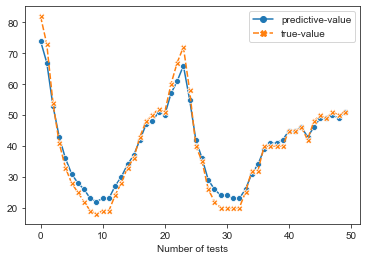

In [167]:
#sns.set(palette="muted", color_codes=True)    # seaborn样式
# plt.rcParams['font.sans-serif'] = ['SimHei']  # 黑体
# plt.rcParams['axes.unicode_minus'] = False    # 解决无法显示符号的问题

sns.set_style('ticks')   #默认五种风格：darkgrid，whitegrid，dark，white，ticks
#sns.set(font='SimHei')#, font_scale=0.8)        # 解决Seaborn中文显示问题

fig=sns.lineplot(data=df,markers=True)
plt.xlabel("Number of tests")
#plt.ylabel("test value")
scatter_fig = fig.get_figure()
scatter_fig.savefig('./pic/CS-BP-Adaboost-Predict', dpi = 400)

In [169]:
True_result = np.array(TestY.values)
True_result

array([82, 73, 54, 41, 33, 28, 25, 22, 19, 18, 19, 19, 24, 28, 33, 36, 43,
       48, 50, 52, 51, 60, 67, 72, 58, 40, 35, 26, 22, 20, 20, 20, 20, 25,
       32, 32, 40, 40, 40, 40, 45, 45, 46, 42, 48, 50, 49, 51, 50, 51],
      dtype=int64)

In [187]:
diff_result = abs(True_result-models_pre_ds[3])
len(diff_result)
diff_result1 = abs(True_result-result1)


In [188]:
diff_result /= 2
diff_result = np.floor(diff_result)
diff_result

array([4., 3., 0., 1., 1., 1., 1., 2., 2., 2., 2., 2., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 1., 3., 3., 0., 1., 1., 1., 2., 2., 2., 2., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [189]:
diff_result1 /= 2
diff_result1 = np.floor(diff_result1)
diff_result1

array([4., 2., 0., 0., 1., 1., 1., 1., 2., 2., 1., 2., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 2., 3., 1., 0., 0., 1., 1., 2., 2., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

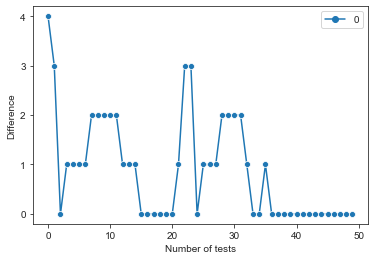

In [211]:
x = list(range(0,len(diff_result)))
fig=sns.lineplot(data = pd.DataFrame(diff_result),markers=True)
fig.set_yticks(ticks=[0,1,2,3,4])
plt.xlabel("Number of tests")
plt.ylabel("Difference")
#plt.ylabel("test value")
scatter_fig = fig.get_figure()
scatter_fig.savefig('./pic/Tent-CS-BP-Predict-diff', dpi = 400)

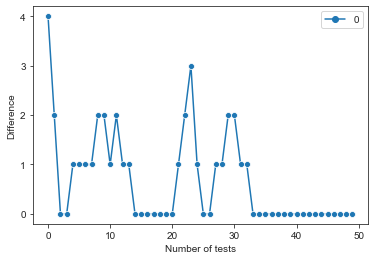

In [212]:
x = list(range(0,len(diff_result)))
fig=sns.lineplot(data = pd.DataFrame(diff_result1),markers=True)
fig.set_yticks(ticks=[0,1,2,3,4])
plt.xlabel("Number of tests")
plt.ylabel("Difference")
#plt.ylabel("test value")
scatter_fig = fig.get_figure()
scatter_fig.savefig('./pic/CS-BP-Adaboost-Predict-diff', dpi = 400)

In [215]:
diff_result
zero = 0 
one = 0 
two = 0
three = 0
four = 0
for i in range(0,len(diff_result)):
    if diff_result[i] == 0:
        zero = zero +1 
    elif diff_result[i] ==1:
        one = one + 1
    elif diff_result[i] == 2:
        two = two + 1 
    elif diff_result[i] == 3:
        three = three +1
    elif diff_result[i] == 4:
        four = four +1
print(zero,one,two,three,four)

24 13 9 3 1


In [216]:
zero = 0 
one = 0 
two = 0
three = 0
four = 0
for i in range(0,len(diff_result1)):
    if diff_result1[i] == 0:
        zero = zero + 1
    elif diff_result1[i] == 1:
        one = one + 1
    elif diff_result1[i] == 2:
        two = two + 1
    elif diff_result1[i] == 3:
        three = three +1 
    elif diff_result1[i] == 4:
        four = four + 1
print(zero,one,two,three,four)

28 13 7 1 1
